**Librerías a utilizar en el código**

In [ ]:
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import v2
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import torch.nn.functional as F

**Extracción de características**

Primero extraemos la media y desviación estándar de las imágenes para normalizar nuestra data. Posteriormente a esto transformamos la data a escala de grises, un formato de 64x64 pixeles, a tensor y normalizada. Separamos la data en 80% de entrenamiento y 20% de validación.

In [ ]:
# Directorio donde se tiene la data de los kanjis
myDir = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kkanji2'
# Paso 1: Cargar las imágenes sin normalizar para calcular la media y la desviación estándar
transform_no_norm = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.ToTensor()  # Convertir las imágenes a tensores (sin normalizar)
])
# Carga dataset temporal para cálculo de estadísticas
temp_dataset = torchvision.datasets.ImageFolder(
    root=myDir,
    transform=transform_no_norm
)
# Crea un DataLoader para cargar todas las imágenes en memoria
temp_loader = DataLoader(temp_dataset, batch_size=len(temp_dataset), shuffle=False)
# Extraer todas las imágenes para calcular la media y desviación estándar
data = next(iter(temp_loader))[0]  # Obtiene los tensores de las imágenes (ignora las etiquetas)
mean = data.mean().item()  # Calcular la media
std = data.std().item()    # Calcular la desviación estándar
# Transforma las imágenes a escala de grises, 64x64, tensor y normaliza
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.Resize((64, 64)),  # Redimensionar a 64x64
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((mean,), (std,)),  # Normalización
])
# Usa ImageFolder para cargar las imágenes
dataset = torchvision.datasets.ImageFolder(
    root=myDir,  # Directorio con las subcarpetas de los kanjis
    transform=transform  # Aplicar las transformaciones a las imágenes
)
# Se divide el dataset en entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Guardamos los 2 datasets para no volver a ejecutar desde 0
torch.save(train_dataset, 'train_dataset.pth')
torch.save(test_dataset, 'test_dataset.pth')
# Se imprime la media y desviacion estandar
print(mean,std)

0.21897509694099426 0.3796195983886719


Guardamos la media y std como un archivo txt para poder ser utilizada sin tener que volver a calcularla

In [ ]:
ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/meanx.txt'
with open(ruta_del_archivo, 'w') as file:
    file.write(str(mean))
ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/stdx.txt'
with open(ruta_del_archivo, 'w') as file:
    file.write(str(std))

Podemos cargar la media y desviación estándar con sus valores

In [ ]:
mean=0.21897509694099426
std=0.3796195983886719

Tambien podemos cargar la media y desviación estándar mediante los archivos de txt guardados

In [ ]:
# Leer el archivo mean.txt
ruta_mean = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/mean.txt'
with open(ruta_mean, 'r') as file:
    mean = eval(file.read())

# Leer el archivo std.txt
ruta_std = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/std.txt'
with open(ruta_std, 'r') as file:
    std = eval(file.read())

print("Mean:", mean)
print("Std:", std)

**Data augmentation**

Con nuestra misma data realizaremos una aumentación de los datos, básicamente tendremos el doble de data. Esta nueva data será rotada entre -10 y 10 grados, con un ZoomOut(Alejamiento) de entre un 1.5 y 3.5, que es como si se colocara la imagen en un nuevo recuadro entre 1.5 y 3.5 veces más grande, disminuyendo así su tamaño, una traslación del 10% aleatorio en el eje vertical y un 10% en el eje horizontal. Finalmente un resize a 64x64, convertirlo en tensor y normalizarlo. Igualmente separamos en data de entrenamiento y de validación.

In [ ]:
# Directorio donde se tiene la data de los kanjis
myDir = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kkanji2'
# Cambios de la data augmentation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises
    transforms.RandomRotation(10),  # Rotación aleatoria de -10 a 10 grados
    #transforms.v2.RandomZoomOut(fill)
    transforms.v2.RandomZoomOut(fill=0, side_range=(1.5, 3.5), p=1),
    transforms.RandomAffine(0, translate=(0.1, 0.1),fill=0),
    transforms.Resize((64, 64)),  # Redimensionar a 64x64
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize((mean,), (std,)),  # Normalización
])
# Usar ImageFolder para cargar las imágenes
dataset = torchvision.datasets.ImageFolder(
    root=myDir,  # Directorio con las subcarpetas de los kanjis
    transform=transform  # Aplicar las transformaciones a las imágenes
)
# Dividir el dataset en entrenamiento y validación (80% entrenamiento, 20% validación)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Guardamos los 2 datasets para no volver a ejecutar desde 0
torch.save(train_dataset, 'train_dataset_zoom.pth')
torch.save(test_dataset, 'test_dataset_zoom.pth')

**Unión de data**

Unimos la data de entrenamiento y de validación en una sola

In [ ]:
train1=torch.load('train_dataset.pth',weights_only=False)
train2=torch.load('train_dataset_zoom.pth',weights_only=False)
test1=torch.load('test_dataset.pth',weights_only=False)
test2=torch.load('test_dataset_zoom.pth',weights_only=False)

In [ ]:
train_dataset = ConcatDataset([train1, train2])
test_dataset = ConcatDataset([test1, test2])

Definimos batches para mejorar el procesamiento y no forzar la RAM

In [ ]:
# Cargar los datos en batches
batch_size_train = 128
batch_size_test = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

Observamos parte de la data

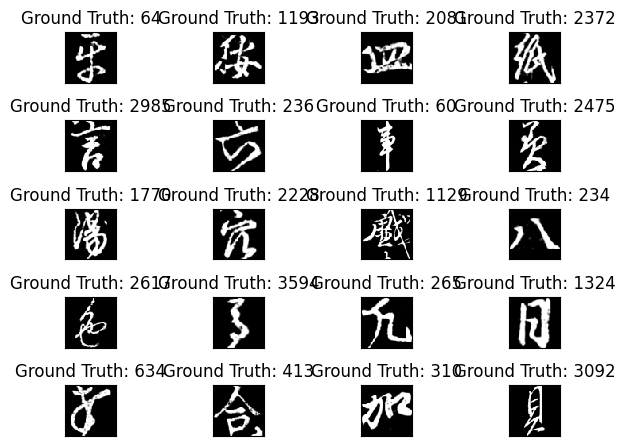

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(20):
  plt.subplot(5,4,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]+1))
  plt.xticks([])
  plt.yticks([])
plt.show()

**Modelo de Red neuronal**

Esta red neuronal cuenta con 3 fases seguidas de convolución, ReLU y MaxPool, un par de drops para evitar overfitting, y linears para obtener finalmente las clasificaciones

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128*6*6, 4000)
        self.fc2 = nn.Linear(4000, 3832)

    def forward(self, x): # Entrada de 1 canal y 64x64 pixeles (1,64,64)
        x = self.conv1(x) # Salida (32,64-3+1,64-3+1)=(32,62,62)
        x = F.relu(x) # Salida (32,62,62)
        x = self.pool1(x) # Salida (32,62/2,62/2)=(32,31,31)
        x = self.conv2(x) # Salida (64,31-3+1,31-3+1)=(64,29,29)
        x = F.relu(x) # Salida (64,29,29)
        x = self.pool2(x) # Salida (64,29/2,29/2)=(64,14,14)
        x = self.conv3(x) # Salida (128,14-3+1,14-3+1)=(128,12,12)
        x = F.relu(x) # Salida (128,12,12)
        x = self.pool3(x) # Salida (128,12/2,12/2)=(128,6,6)
        x = self.drop1(x) # Salida (128,6,6)
        x = x.flatten(1) # Salida (128x6x6)
        x = self.fc1(x) # Salida (4000)
        x = F.relu(x) # Salida (4000)
        x = self.drop2(x) # Salida (4000)
        x = self.fc2(x) # Salida (3832)
        x = F.log_softmax(x, dim=1)
        return x

**Entrenamiento del modelo**

Inicialización de los pesos

In [ ]:
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

Cambiamos a "cuda" para poder utilizar la GPU en lugar de la CPU y tener un procesamiento más eficiente

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Inicializamos el modelo, el optimizador y de tener el modelo ya entrenado lo podemos cargar, si se quiere entrenar desde 0 otro modelo se puede comentar la parte de "model.load_state_dict"

In [ ]:
# Inicializar modelo
model = Net().to(device)
# Initializar pesos
model.apply(weights_init)
# Definir optimizador
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
# Cargar modelo ya guardado (Comentar si se quiere empezar de 0)
model.load_state_dict(torch.load("modelo_kanji_3800_completo_500.pth",weights_only=False))


<All keys matched successfully>

Definimos nuestra función de entrenamiento

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Mover datos a GPU si está disponible
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  # Limpiar gradientes acumulados
        output = model(data)  # Forward pass
        loss = F.nll_loss(output, target)  # Calcular pérdida
        loss.backward()  # Backward pass
        optimizer.step()  # Actualizar pesos

        # Registro periódico
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

Definimos nuestra función de testeo

In [ ]:
# Run on test data
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Desactiva gradientes
        for data, target in test_loader:
            # Mover datos a GPU si está disponible
            data, target = data.to(device), target.to(device)

            output = model(data)  # Forward pass
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # Pérdida acumulada
            pred = output.argmax(dim=1, keepdim=True)  # Predicciones
            correct += pred.eq(target.view_as(pred)).sum().item()  # Acumular correctos

    # Pérdida promedio
    test_loss /= len(test_loader.dataset)

    # Imprimir resultados
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Realizamos el entrenamiento de nuestro modelo, el número de epocas se puede cambiar, además de usar un modelo cargado, este puede seguir entrenandose, para este caso se entrenó por 500 épocas, pero en varias sesiones, no las 500 de golpe

In [ ]:
import torch.nn.functional as F
# Get initial performance
test()
# Train for three epochs
n_epochs = 100
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 0.6410, Accuracy: 49414/56170 (88%)

Train Epoch: 1 [0/224678]	Loss: 0.409756
Train Epoch: 1 [1280/224678]	Loss: 0.348294
Train Epoch: 1 [2560/224678]	Loss: 0.389401
Train Epoch: 1 [3840/224678]	Loss: 0.662357
Train Epoch: 1 [5120/224678]	Loss: 0.415842
Train Epoch: 1 [6400/224678]	Loss: 0.557353
Train Epoch: 1 [7680/224678]	Loss: 0.417834
Train Epoch: 1 [8960/224678]	Loss: 0.508892
Train Epoch: 1 [10240/224678]	Loss: 0.347848
Train Epoch: 1 [11520/224678]	Loss: 0.549650
Train Epoch: 1 [12800/224678]	Loss: 0.633425
Train Epoch: 1 [14080/224678]	Loss: 0.429064
Train Epoch: 1 [15360/224678]	Loss: 0.458551
Train Epoch: 1 [16640/224678]	Loss: 0.509330
Train Epoch: 1 [17920/224678]	Loss: 0.427406
Train Epoch: 1 [19200/224678]	Loss: 0.387988
Train Epoch: 1 [20480/224678]	Loss: 0.542485
Train Epoch: 1 [21760/224678]	Loss: 0.708319
Train Epoch: 1 [23040/224678]	Loss: 0.560759
Train Epoch: 1 [24320/224678]	Loss: 0.635512
Train Epoch: 1 [25600/224678]	Loss: 0.480791
Train E

Guardar el modelo que se tiene actualmente

In [ ]:
torch.save(model.state_dict(), "modelo_kanji_3800_completo_500x.pth")

**Visualización de la validación**

Visualización de algunas predicciones de nuestra data de validación

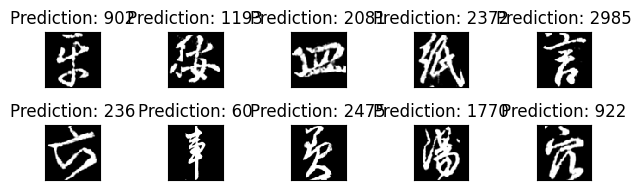

In [ ]:
output = model(example_data.to(device))

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()+1))
  plt.xticks([])
  plt.yticks([])
plt.show()

Para una mejor predicción se utilizará una pizarra interactiva en donde se sabrá si el kanji realizado coincide con lo escrito, para esto primero obtenemos los "Unicode" de las carpetas donde tenemos las imágenes de los kanji, estos unicodes son estándares de codificación, y podemos transformarlos para mostrar el kanji como el propio caracter.

In [ ]:
unicode_carpetas=[]
ruta_principal = "C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kkanji2"  # Cambia esto a tu ruta
for carpeta in os.listdir(ruta_principal):
    ruta_carpeta = os.path.join(ruta_principal, carpeta)
    if os.path.isdir(ruta_carpeta):
        num_archivos = len([f for f in os.listdir(ruta_carpeta) if os.path.isfile(os.path.join(ruta_carpeta, f))])
        unicode_carpetas.append(carpeta)

Transformamos los unicodes en los caracteres

In [ ]:
caracteres=[]
for unicode in unicode_carpetas:
    char = chr(int(unicode[2:], 16))
    caracteres.append(char)

**Prueba con pizarra**

Se realizó una pizarra interactiva, en esta dibujas un kanji y al hacer clic en "Predecir kanji" te muestra el kanji predicho, entonces al observar tanto el texto como el dibujo se sabe si se realizó de manera correcta, igualmente podemos guardar la imagen si vemos que es una predicción correcta con el botón de "Guardar imagen"

In [ ]:
import tkinter as tk
from tkinter import Button
import PIL.ImageGrab as ImageGrab
import cv2
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import numpy as np
import os

# Cargar el modelo entrenado
modelo = model.to(device)
modelo.eval()

# Crear la ventana
root = tk.Tk()
root.title("Pizarra de Kanji")

# Canvas de dibujo (ajustado para ser más grande que 28x28 para comodidad)
canvas_size = 256
canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg="black")
canvas.pack()

image1 = Image.new("RGB", (canvas_size, canvas_size), (0,0,0))
draw2 = ImageDraw.Draw(image1)

# Variables para dibujar
def start_drawing(event):
    canvas.old_x, canvas.old_y = event.x, event.y

def draw(event):
    x, y = event.x, event.y
    canvas.create_line(canvas.old_x, canvas.old_y, x, y, width=10, fill="white", capstyle=tk.ROUND, smooth=tk.TRUE)
    draw2.line([canvas.old_x, canvas.old_y, x, y], (255,255,255),width=10)
    canvas.old_x, canvas.old_y = x, y

canvas.bind("<Button-1>", start_drawing)
canvas.bind("<B1-Motion>", draw)

ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/contador.txt'

with open(ruta_del_archivo, 'r') as file:
        contenido = file.read()
contador=int(contenido)
# Función para guardar la imagen y predecir
def guardar_y_predecir():
    image1.save('C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kanjis_dibujados/img1.png')
    # Convertir a tensor y normalizar
    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.Resize((64, 64)),  # Redimensionar las imágenes a 28x28 (como MNIST)
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((mean), (std,)),  # Normalizar las imágenes
])
    imagen_tensor = transform(image1).unsqueeze(0)  # Agregar dimensión batch

    # Hacer la predicción con el modelo
    imagen_tensor = imagen_tensor.to(device)
    salida = model(imagen_tensor)
    prediccion=salida.data.max(1, keepdim=True)[1].item()
    # Mostrar el resultado
    resultado_label.config(text=f"Predicción: {caracteres[prediccion]}")
    return prediccion

def guardar_imagen_con_nombre():
    global contador
    prediccion = guardar_y_predecir()  # Obtiene la predicción actual

    # Carpeta donde se guardarán las imágenes
    save_dir = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kanjis_nuevos/'+f"{unicode_carpetas[prediccion]}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Crear la carpeta si no existe

    # Guardar la imagen con el nombre basado en la predicción
    save_path = os.path.join(save_dir, f"kanji_{contador}.png")
    image1.save(save_path)
    print(f"Imagen guardada como: {save_path}")
    contador+=1

    ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/contador.txt'
    with open(ruta_del_archivo, 'w') as file:
        file.write(str(contador))

# Botón para guardar y predecir
boton_guardar = Button(root, text="Predecir Kanji", command=guardar_y_predecir)
boton_guardar.pack()

boton_guardar_imagen = Button(root, text="Guardar Imagen", command=guardar_imagen_con_nombre)
boton_guardar_imagen.pack()

# Etiqueta para mostrar la predicción
resultado_label = tk.Label(root, text="Dibuja un Kanji y presiona 'Predecir Kanji'", font=("Arial", 14))
resultado_label.pack()

# Botón para limpiar la pizarra
# Función para limpiar el canvas y reiniciar la imagen
def limpiar_canvas():
    # Limpiar el canvas de dibujo
    canvas.delete("all")

    # Reiniciar la imagen asociada
    global image1, draw2
    image1 = Image.new("RGB", (canvas_size, canvas_size), (0, 0, 0))  # Nueva imagen en negro
    draw2 = ImageDraw.Draw(image1)  # Nuevo objeto ImageDraw para la imagen limpia

boton_limpiar = Button(root, text="Limpiar", command=limpiar_canvas)
boton_limpiar.pack()

root.mainloop()


**Pizarra de testeo**

Esta pizarra es similar; sin embargo, se añade un botón de "Escribe un Kanji", este muestra un kanji al azar, entonces el usuario debe escribir el kanji y pulsar "Predecir Kanji", posteriormente a esto "Guardar Imagen", para este caso se muestra el Kanji a Predecir y el Kanji Predicho en pantalla, por lo que se sabría si se obtuvo un acierto o fallo, además al guradr las imágenes, la imágen sea correcta o errónea se guardará en la carpeta con el unicode del Kanji que se debió predecir, finalmente se puede realizar esto un número indefinido de veces y realizar un testeo para calcular el accuracy y otras métricas  del modelo en base al testeo, así mismo esto podría servir para volver a entrenar el modelo para que se ajuste más a trazos de ahora que a trazos antiguos.

In [ ]:
import tkinter as tk
from tkinter import Button
import PIL.ImageGrab as ImageGrab
import cv2
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import numpy as np
import os
import torch.nn.functional as F
# Cargar el modelo entrenado
modelo = model.to(device)
modelo.eval()

# Crear la ventana
root = tk.Tk()
root.title("Pizarra de Kanji")

# Canvas de dibujo (ajustado para ser más grande que 28x28 para comodidad)
canvas_size = 256
canvas = tk.Canvas(root, width=canvas_size, height=canvas_size, bg="black")
canvas.pack()

image1 = Image.new("RGB", (canvas_size, canvas_size), (0,0,0))
draw2 = ImageDraw.Draw(image1)

# Variables para dibujar
def start_drawing(event):
    canvas.old_x, canvas.old_y = event.x, event.y

def draw(event):
    x, y = event.x, event.y
    canvas.create_line(canvas.old_x, canvas.old_y, x, y, width=10, fill="white", capstyle=tk.ROUND, smooth=tk.TRUE)
    draw2.line([canvas.old_x, canvas.old_y, x, y], (255,255,255),width=10)
    canvas.old_x, canvas.old_y = x, y

canvas.bind("<Button-1>", start_drawing)
canvas.bind("<B1-Motion>", draw)

ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/contador.txt'

with open(ruta_del_archivo, 'r') as file:
        contenido = file.read()
contador=int(contenido)
# Función para guardar la imagen y predecir
def guardar_y_predecir():
    global valor
    image1.save('C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kanjis_dibujados/img1.png')

    # Convertir a tensor y normalizar
    transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.Resize((64, 64)),  # Redimensionar las imágenes a 28x28 (como MNIST)
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((mean), (std,)),  # Normalizar las imágenes
])
    imagen_tensor = transform(image1).unsqueeze(0)  # Agregar dimensión batch

    # Hacer la predicción con el modelo
    imagen_tensor = imagen_tensor.to(device)
    salida = model(imagen_tensor)
    prediccion=salida.data.max(1, keepdim=True)[1].item()
    # Mostrar el resultado
    resultado_label.config(text=f"Escribe: {caracteres[valor]}\nPredicción: {caracteres[prediccion]}")
    return prediccion

def guardar_imagen_con_nombre():
    global contador
    global valor
    prediccion = guardar_y_predecir()  # Obtiene la predicción actual

    # Carpeta donde se guardarán las imágenes
    save_dir = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kanjis_nuevos/'+f"{unicode_carpetas[valor]}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)  # Crear la carpeta si no existe

    # Guardar la imagen con el nombre basado en la predicción
    save_path = os.path.join(save_dir, f"kanji_{contador}.png")
    image1.save(save_path)
    print(f"Imagen guardada como: {save_path}")
    contador+=1

    ruta_del_archivo = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/contador.txt'
    with open(ruta_del_archivo, 'w') as file:
        file.write(str(contador))

def azar():
    global valor
    valor= np.random.randint(0, len(caracteres))
    # Mostrar el resultado
    resultado_label.config(text=f"Escribe: {caracteres[valor]}")
    return valor

# Botón para guardar y predecir

boton_azar = Button(root, text="Escribe un Kanji", command=azar)
boton_azar.pack()

boton_guardar = Button(root, text="Predecir Kanji", command=guardar_y_predecir)
boton_guardar.pack()

boton_guardar_imagen = Button(root, text="Guardar Imagen", command=guardar_imagen_con_nombre)
boton_guardar_imagen.pack()

# Etiqueta para mostrar la predicción
resultado_label = tk.Label(root, text="Dibuja un Kanji y presiona 'Predecir Kanji'", font=("Arial", 14))
resultado_label.pack()

# Botón para limpiar la pizarra
# Función para limpiar el canvas y reiniciar la imagen
def limpiar_canvas():
    # Limpiar el canvas de dibujo
    canvas.delete("all")

    # Reiniciar la imagen asociada
    global image1, draw2
    image1 = Image.new("RGB", (canvas_size, canvas_size), (0, 0, 0))  # Nueva imagen en negro
    draw2 = ImageDraw.Draw(image1)  # Nuevo objeto ImageDraw para la imagen limpia

boton_limpiar = Button(root, text="Limpiar", command=limpiar_canvas)
boton_limpiar.pack()

root.mainloop()

**Testeo**

Con los kanjis guardados con la pizarra podemos realizar el testeo para calcular las métricas

In [ ]:
myDir = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kanjis_nuevos'

# Definir las transformaciones para las imágenes
transform = transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convertir a escala de grises (si es necesario)
    transforms.Resize((64, 64)),  # Redimensionar las imágenes a 28x28 (como MNIST)
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((mean,), (std,)),  # Normalizar las imágenes
])

# Usar ImageFolder para cargar las imágenes
dataset = torchvision.datasets.ImageFolder(
    root=myDir,  # Directorio con las subcarpetas de los kanjis
    transform=transform  # Aplicar las transformaciones a las imágenes
)
# Cargar los datos en batches
batch_size_test2 = 200
test_loader2 = DataLoader(dataset, batch_size=batch_size_test2, shuffle=False)

Observamos parte de la data guardada

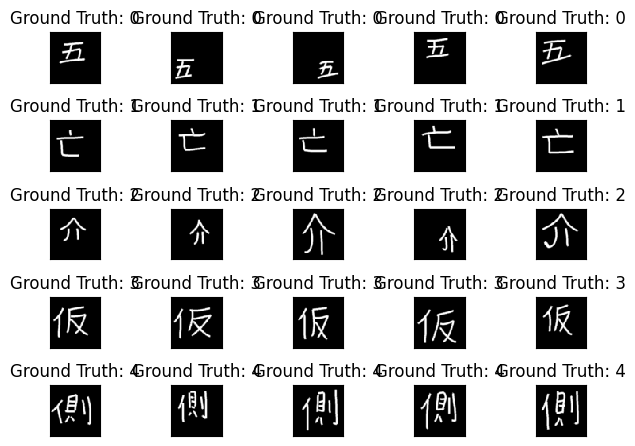

In [ ]:
import matplotlib.pyplot as plt
# Let's draw some of the training data
examples = enumerate(test_loader2)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Predicciones de parte de la data de testeo

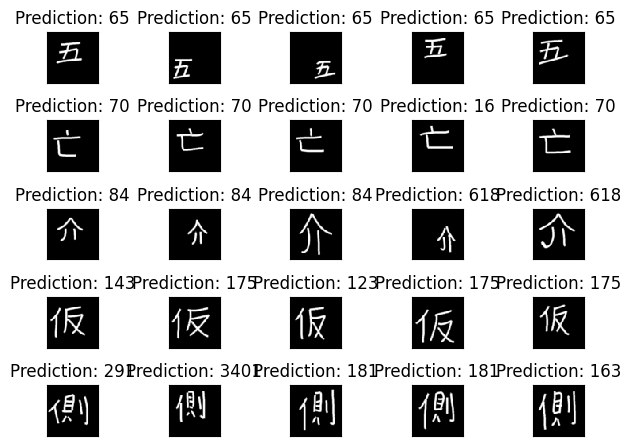

In [ ]:
model.eval()
output = model(example_data.to(device))

fig = plt.figure()
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()+1))
  plt.xticks([])
  plt.yticks([])
plt.show()

Obtenemos las predicciones y las transformamos a su Unicode

In [ ]:
predicciones1=[]
for i in range(len(output)):
    predicciones1.append(output.data.max(1, keepdim=True)[1][i].item())

In [ ]:
unicode_predicciones=[unicode_carpetas[i] for i in predicciones1]

Obtenemos los Unicode reales de las imágenes

In [ ]:
import os
import numpy as np

ruta_principal = 'C:/Users/bryan/Documents/8-9/Machine_Learning/Abc/pythonProject/kanjis/kanjis_nuevos' # Cambia esto a la ruta de tu carpeta principal

# Lista todas las carpetas dentro de la ruta principal
carpetas = [f for f in os.listdir(ruta_principal) if os.path.isdir(os.path.join(ruta_principal, f))]

# Crear el array con los nombres repetidos según la cantidad de archivos dentro
unicode_real = []

for carpeta in carpetas:
    ruta_carpeta = os.path.join(ruta_principal, carpeta)
    num_archivos = len([f for f in os.listdir(ruta_carpeta) if os.path.isfile(os.path.join(ruta_carpeta, f))])
    unicode_real=unicode_real+[carpeta] * num_archivos  # Repite el nombre según la cantidad de archivos

['U+4E94', 'U+4E94', 'U+4E94', 'U+4E94', 'U+4E94', 'U+4EA1', 'U+4EA1', 'U+4EA1', 'U+4EA1', 'U+4EA1', 'U+4ECB', 'U+4ECB', 'U+4ECB', 'U+4ECB', 'U+4ECB', 'U+4EEE', 'U+4EEE', 'U+4EEE', 'U+4EEE', 'U+4EEE', 'U+5074', 'U+5074', 'U+5074', 'U+5074', 'U+5074', 'U+5185', 'U+5185', 'U+5185', 'U+5185', 'U+5185', 'U+52FF', 'U+52FF', 'U+52FF', 'U+52FF', 'U+52FF', 'U+5302', 'U+5302', 'U+5302', 'U+5302', 'U+5302', 'U+53CB', 'U+53CB', 'U+53CB', 'U+53CB', 'U+53CB', 'U+53DB', 'U+53DB', 'U+53DB', 'U+53DB', 'U+53DB', 'U+53F3', 'U+53F3', 'U+53F3', 'U+53F3', 'U+53F3', 'U+5484', 'U+5484', 'U+5484', 'U+5484', 'U+5484', 'U+56DE', 'U+56DE', 'U+56DE', 'U+56DE', 'U+56DE', 'U+56E0', 'U+56E0', 'U+56E0', 'U+56E0', 'U+56E0', 'U+5931', 'U+5931', 'U+5931', 'U+5931', 'U+5931', 'U+5982', 'U+5982', 'U+5982', 'U+5982', 'U+5982', 'U+59CB', 'U+59CB', 'U+59CB', 'U+59CB', 'U+59CB', 'U+5B89', 'U+5B89', 'U+5B89', 'U+5B89', 'U+5B89', 'U+5C48', 'U+5C48', 'U+5C48', 'U+5C48', 'U+5C48', 'U+5DDD', 'U+5DDD', 'U+5DDD', 'U+5DDD', 'U+5DDD',

Finalmente con los labels reales y predichos podemos calcular el accuracy, precision, recall y f1 score. Para este caso se tuvo un accuracy de 35.50%, un precision de 15.46%, recall de 11.93% y f1 score de 13.01%. A pesar de ser valores tan bajos, esto puede deberse a que el trazado en la pizarra no se compara a un trazado en lapiz y papel donde el grosor del pincel podría variar o también debido a la transformación del kanji a traves del tiempo, ya que la data es de manuscritos antiguos en donde los kanjis pudieron tener cambios, además de ser kanjis deformados, lo cuál no reflejaría a la escritura moderna.

In [ ]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calcular accuracy
accuracy = accuracy_score(unicode_real, unicode_predicciones)
precision = precision_score(unicode_real, unicode_predicciones, average='macro', zero_division=0)
recall = recall_score(unicode_real, unicode_predicciones, average='macro', zero_division=0)
f1 = f1_score(unicode_real, unicode_predicciones, average='macro', zero_division=0)
print(f"Accuracy: {accuracy*100:.2f}%")  # Resultado entre 0 y 1
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")

Accuracy: 35.50%
Precision: 15.46%
Recall: 11.93%
F1-score: 13.01%
